In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load datasets
us_disaster_data = pd.read_csv("https://raw.githubusercontent.com/pauladel/DS3001-Project/refs/heads/main/raw-data/us_disaster_declarations.csv")
empg_data = pd.read_parquet('https://www.fema.gov/api/open/v2/EmergencyManagementPerformanceGrants.parquet')

# Display initial rows to understand structure
us_disaster_data.head()

,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,ih_program_declared,ia_program_declared,...,incident_end_date,disaster_closeout_date,fips,place_code,designated_area,declaration_request_number,last_ia_filing_date,last_refresh,hash,id
0,DR-1-GA,1,GA,DR,1953-05-02T00:00:00Z,1953,Tornado,Tornado,0,1,...,1953-05-02T00:00:00Z,1954-06-01T00:00:00Z,13000,0,Statewide,53013,NaN,2023-03-18T13:22:03Z,48af1afcc4535aa910ddb5b85eebe047dc703a6b,da5c8f17-c28f-4c41-8e06-fa8efc85aa4a
1,DR-2-TX,2,TX,DR,1953-05-15T00:00:00Z,1953,Tornado,Tornado & Heavy Rainfall,0,1,...,1953-05-15T00:00:00Z,1958-01-01T00:00:00Z,48000,0,Statewide,53003,NaN,2023-03-18T13:22:03Z,6bbba411d294ec521683e36313c8da2992e8a857,b0b41f55-0d77-43ac-898c-3cc4a18231e6
2,DR-3-LA,3,LA,DR,1953-05-29T00:00:00Z,1953,Flood,Flood,0,1,...,1953-05-29T00:00:00Z,1960-02-01T00:00:00Z,22000,0,Statewide,53005,NaN,2023-03-18T13:22:03Z,5b2fa18b404bdcf0d3038cd17f1aa995d5412f48,9fd9401d-c76c-43c3-b42a-6a4ae5139ec0
3,DR-4-MI,4,MI,DR,1953-06-02T00:00:00Z,1953,Tornado,Tornado,0,1,...,1953-06-02T00:00:00Z,1956-02-01T00:00:00Z,26000,0,Statewide,53004,NaN,2023-03-18T13:22:03Z,403164346eb22263810402e8b67f1712f1574ad5,67324f38-1f00-4bbc-aeda-5194d1befad6
4,DR-5-MT,5,MT,DR,1953-06-06T00:00:00Z,1953,Flood,Floods,0,1,...,1953-06-06T00:00:00Z,1955-12-01T00:00:00Z,30000,0,Statewide,53006,NaN,2023-03-18T13:22:03Z,8c775d2ce843a8eba2417f9716ba5c75fe0e53f3,e3853916-c7a2-4557-ad8e-60a42d369a61


In [ ]:
empg_data.head()

,id,reportingPeriod,state,legalAgencyName,projectType,projectStartDate,projectEndDate,nameOfProgram,fundingAmount
0,d2c2ec70-43e5-4fee-a94b-b4d27386e618,2014 Close-Out,Alabama,Alabama Emergency Management Agency,"Develop/enhance plans, procedures, and protocols",2014-10-01,2016-10-01,EMPG,5795991.00
1,fcfb351a-a101-4073-940e-f1d83d61d8af,2014 Close-Out,Alaska,City and Borough of Juneau,Establish/Enhance emergency plans and procedur...,2014-07-01,2015-06-01,EMPG,110000.00
2,3728aea6-7390-46b0-90fb-4ad9390d3ab3,2014 Close-Out,Alaska,City of Cordova,Establish/Enhance emergency plans and procedur...,2014-07-01,2015-06-01,EMPG,18000.00
3,18b2a863-0c9a-4c26-a722-db81bbd3d3b8,2014 Close-Out,Alaska,City of Dillingham,Establish/Enhance emergency plans and procedur...,2014-07-01,2015-06-01,EMPG,2672.65
4,a071b178-7d78-472e-a8e7-e1c132e3d797,2014 Close-Out,Alaska,City of Fairbanks,Establish/Enhance emergency plans and procedur...,2014-07-01,2015-06-01,EMPG,10000.00


In [4]:
import pandas as pd

# Predefined dictionary mapping state abbreviations to full names
state_abbreviation_map = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Replace state abbreviations with full names
us_disaster_data['state'] = us_disaster_data['state'].map(state_abbreviation_map)

# Check updated dataframe
print(us_disaster_data[['state']].head())


       state
0    Georgia
1      Texas
2  Louisiana
3   Michigan
4    Montana


In [5]:
# Aggregate disaster data by state and disaster type
disaster_summary = us_disaster_data.groupby(['state', 'incident_type']).size().unstack(fill_value=0)
disaster_summary['total_disasters'] = disaster_summary.sum(axis=1)

# Aggregate EMPG funding by state
funding_summary = empg_data.groupby('state')['fundingAmount'].sum().reset_index()


# Merge datasets on the 'state' column
clustering_data = pd.merge(disaster_summary, funding_summary, on='state')

# Optional: Set 'state' as the index for easy access later
clustering_data.set_index('state', inplace=True)

# Display the merged dataset
print(clustering_data.head())



            Biological  Chemical  Coastal Storm  Dam/Levee Break  Drought  \
state                                                                       
Alabama            139         0              0                0       67   
Alaska             121         0              2                0        0   
Arizona             73         0              0                0        8   
Arkansas           152         0              0                0       32   
California         116         0             43                5       47   

            Earthquake  Fire  Fishing Losses  Flood  Freezing  ...  Terrorist  \
state                                                          ...              
Alabama              0    11               0    104         0  ...          0   
Alaska              13    30               0     50        14  ...          0   
Arizona              0    88               0     82         1  ...          0   
Arkansas             0     0               0    271    

In [6]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Convert back to DataFrame for readability
scaled_data_df = pd.DataFrame(scaled_data, index=clustering_data.index, columns=clustering_data.columns)


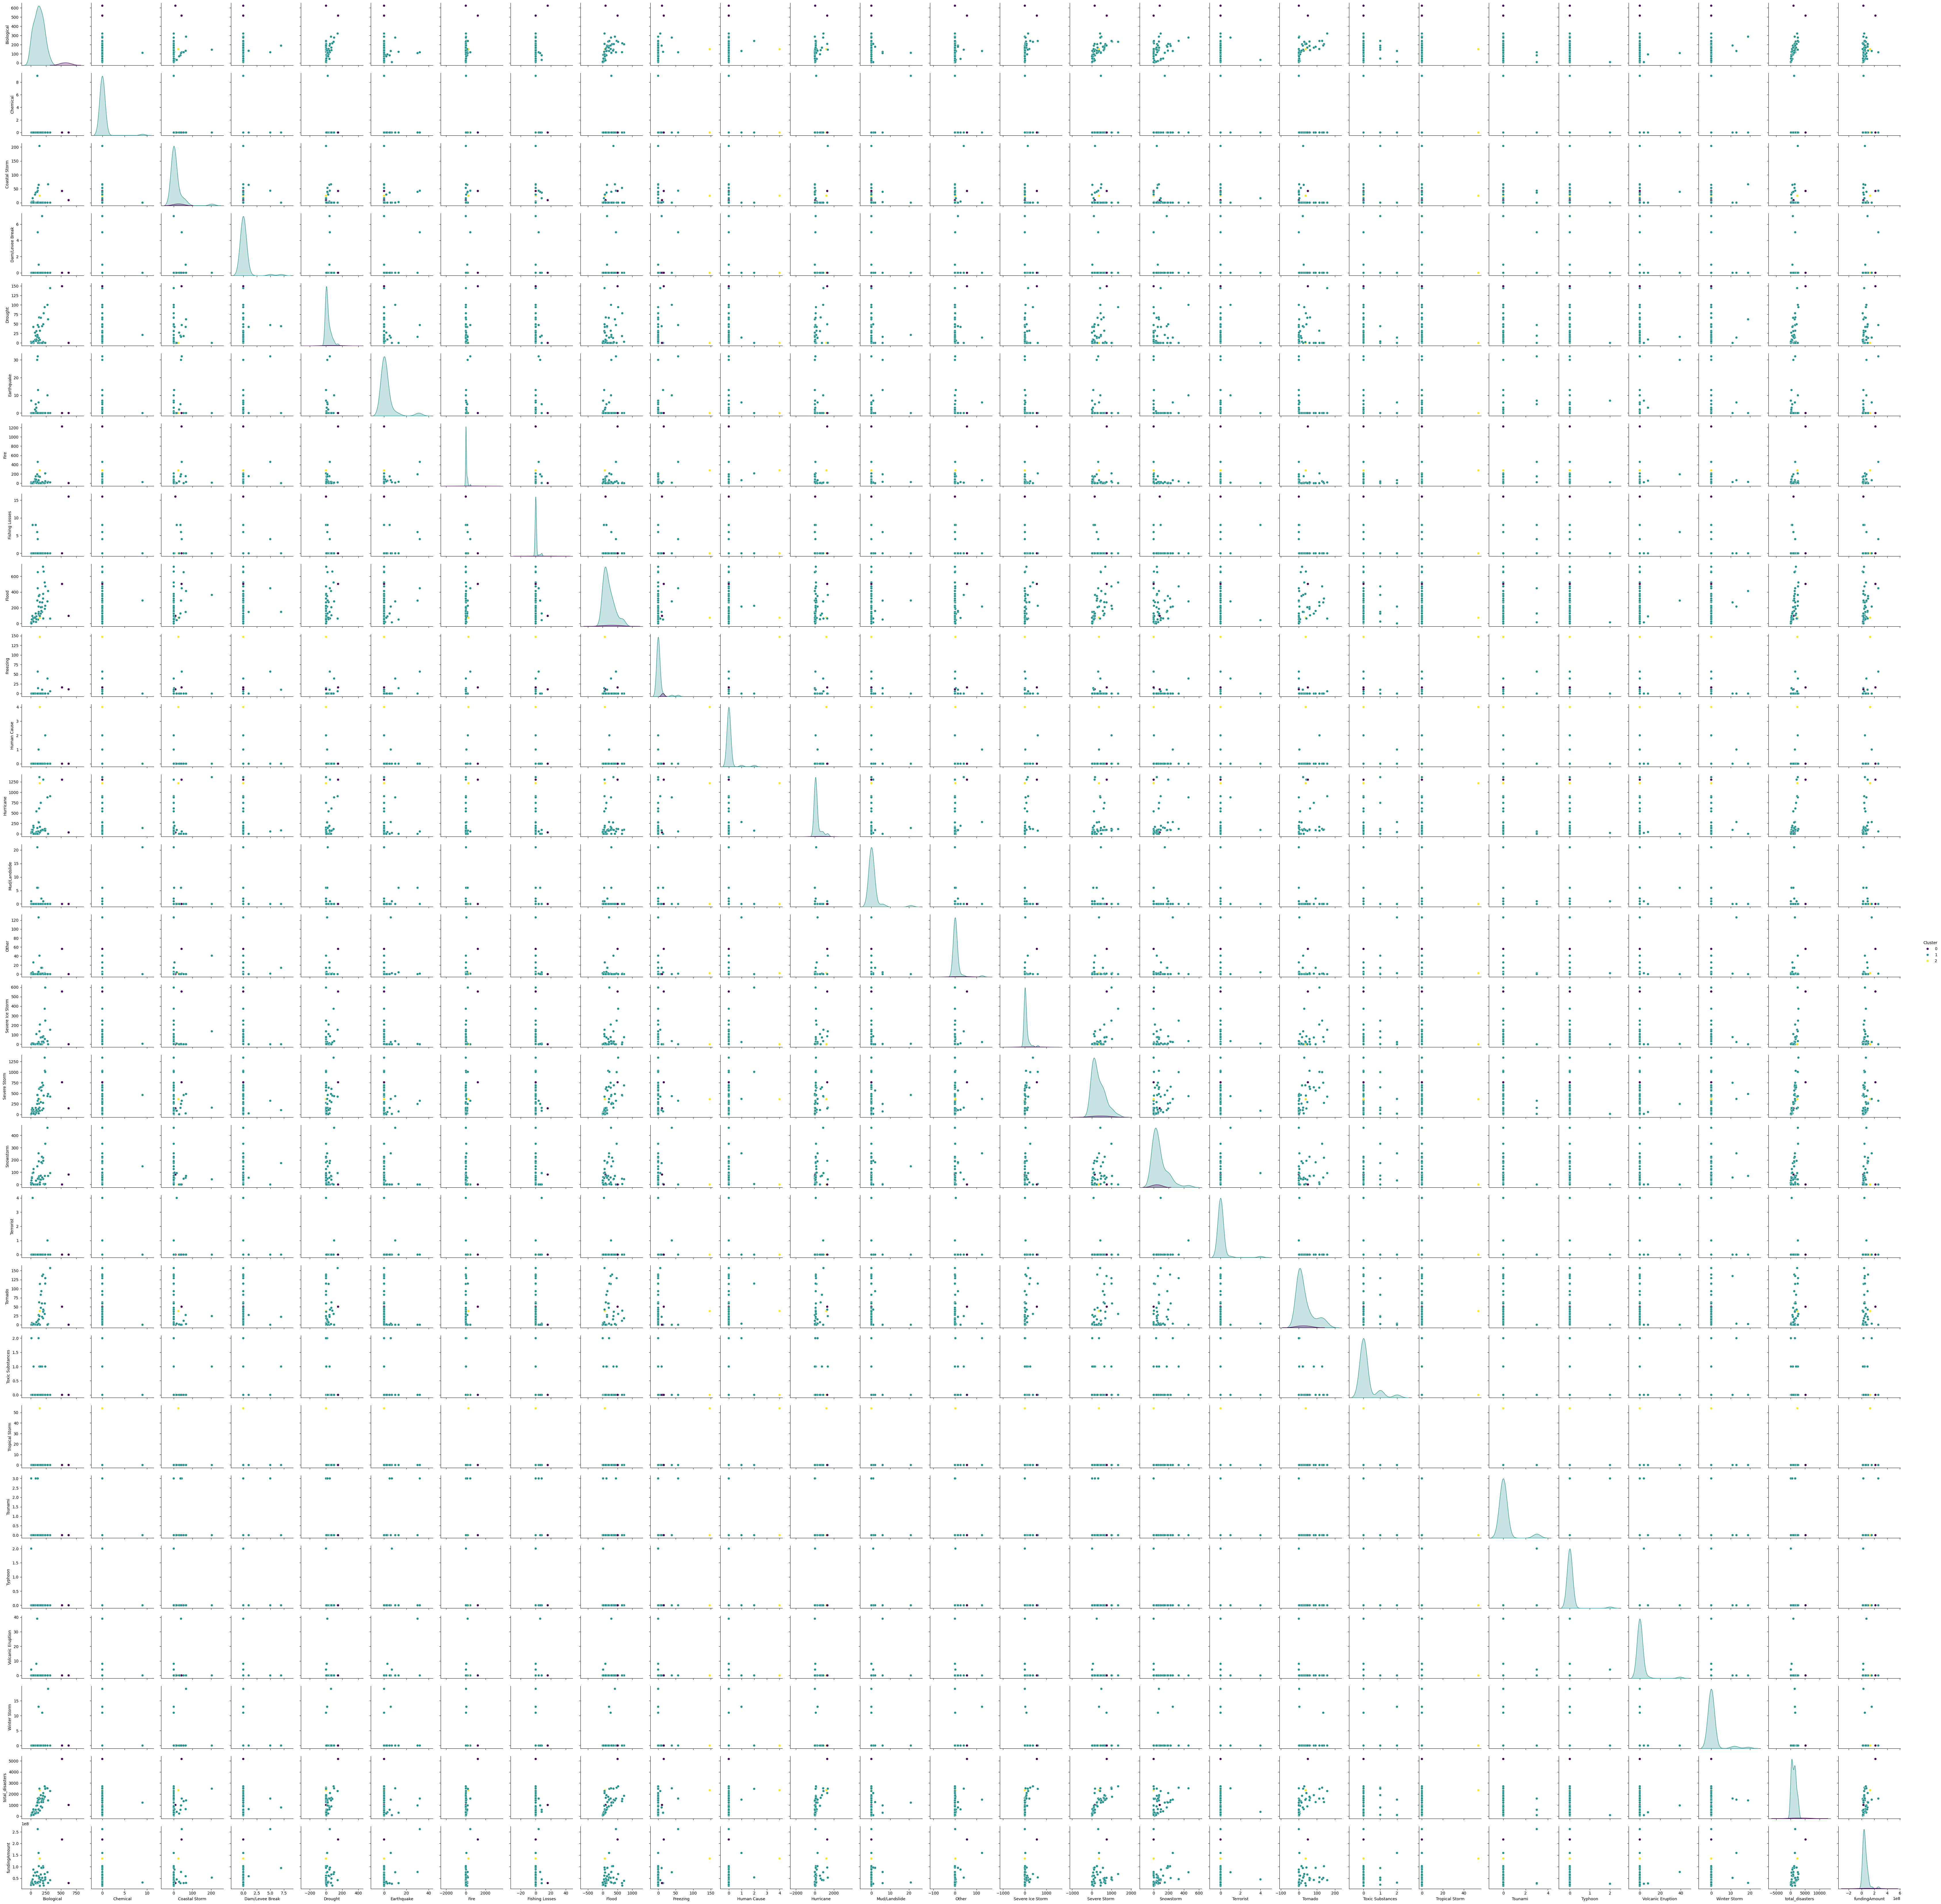

In [ ]:
optimal_k = 3  # Choose based on elbow/silhouette
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clustering_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize clusters
sns.pairplot(clustering_data, hue='Cluster', palette='viridis', diag_kind='kde')
plt.show()


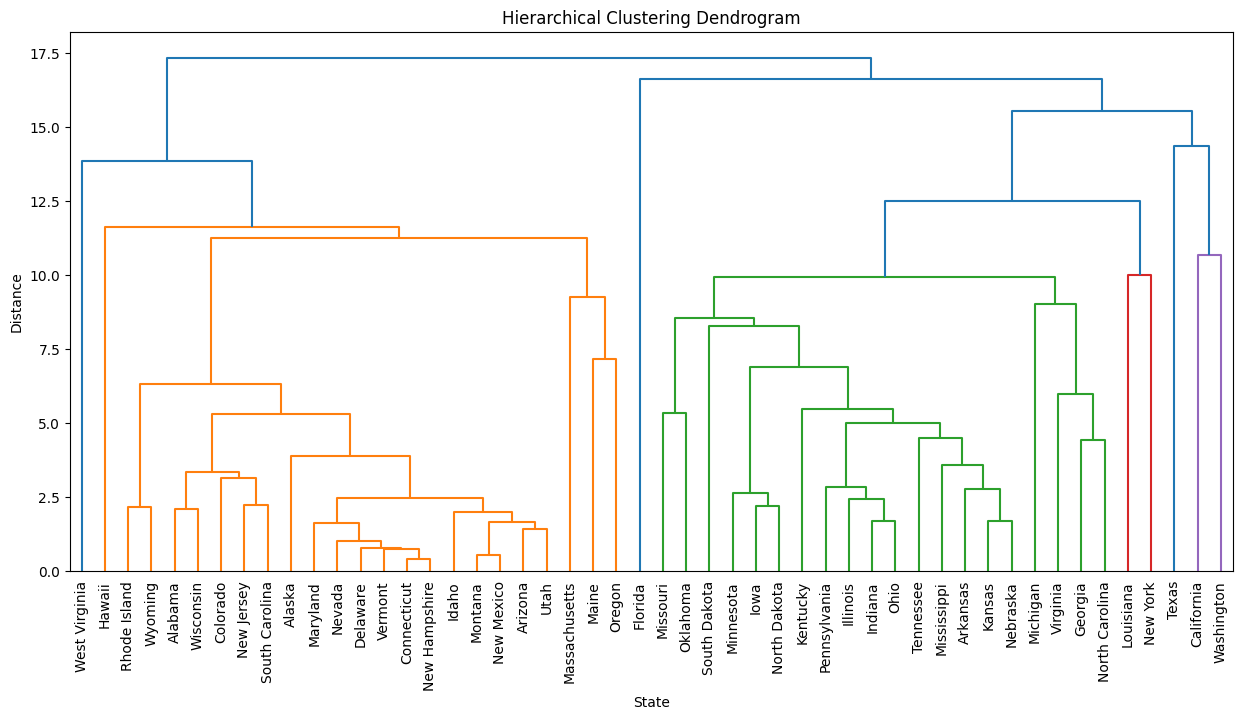

In [ ]:
linkage_matrix = linkage(scaled_data, method='ward')
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, labels=clustering_data.index, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("State")
plt.ylabel("Distance")
plt.show()


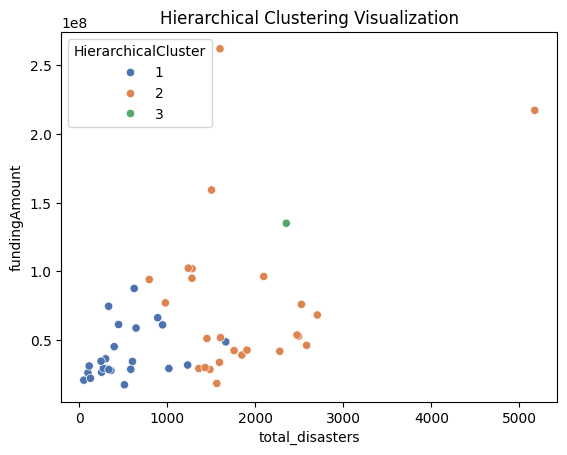

In [ ]:
from scipy.cluster.hierarchy import fcluster

hierarchical_clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')
clustering_data['HierarchicalCluster'] = hierarchical_clusters

# Visualize cluster assignments
sns.scatterplot(data=clustering_data, x='total_disasters', y='fundingAmount', hue='HierarchicalCluster', palette='deep')
plt.title("Hierarchical Clustering Visualization")
plt.show()


In [ ]:
# Display cluster means
print(clustering_data.groupby('Cluster').mean())


         Biological  Chemical  Coastal Storm  Dam/Levee Break    Drought  \
Cluster                                                                    
0        569.000000  0.000000      25.500000         0.000000  74.500000   
1        135.829787  0.191489      11.914894         0.276596  22.893617   
2        150.000000  0.000000      25.000000         0.000000   0.000000   

         Earthquake        Fire  Fishing Losses       Flood    Freezing  ...  \
Cluster                                                                  ...   
0          0.000000  613.500000        8.000000  299.500000   13.500000  ...   
1          2.319149   44.744681        0.553191  205.085106    2.702128  ...   
2          0.000000  277.000000        0.000000   73.000000  147.000000  ...   

           Tornado  Toxic Substances  Tropical Storm   Tsunami   Typhoon  \
Cluster                                                                    
0        25.000000          0.000000             0.0  0.000000  0.

1. General Overview
Each row represents a cluster (e.g., Cluster 0, Cluster 1, Cluster 2).
Each column represents a feature (e.g., types of disasters, total_disasters, fundingAmount).
The values are the averages of those features within each cluster.
The clustering groups states (or data points) into three distinct categories based on their similarities in disaster frequency, type, and funding.

2. What Each Cluster Represents
To interpret these clusters, look at the dominant features (high values) for each cluster:

Cluster 0:
High values for:
Biological disasters (569) and total_disasters (3096).
FundingAmount is the highest at 1.233e+08 (substantially larger than the others).
Characteristics:
Likely represents states with high overall disaster activity, especially biological-related disasters, and significant disaster funding.
Cluster 1:
Moderate values for:
Tornadoes (31.51), Floods (205.08), and Fire (44.74).
Total disasters (1132) and FundingAmount (5.596e+07).
Characteristics:
States in this cluster likely experience a moderate number of disasters of varying types, especially tornadoes and floods, and receive moderate funding.
Cluster 2:
High values for:
Tornadoes (38), Freezing (147), and total_disasters (2352).
Funding is 1.350e+08, slightly higher than Cluster 1.
Characteristics:
This cluster likely represents states that are affected more by tornadoes and freezing-related disasters and have moderate disaster activity with relatively high funding.
3. Funding Insights
Cluster 0 receives the most funding (
1.233
×
1
0
8
1.233×10
8
 ), likely because it has the highest total disasters (3096) and high biological disaster activity.
Cluster 1 receives the least funding (
5.596
×
1
0
7
5.596×10
7
 ), corresponding to states with fewer disasters and moderate disaster types.
Cluster 2 receives slightly more funding than Cluster 1, likely due to high tornado and freezing activity.
4. Key Takeaways
The K-Means clustering successfully groups states into clusters based on disaster activity and funding:

High-disaster, high-funding states (Cluster 0).
Moderate-disaster, moderate-funding states (Cluster 1).
Tornado-/freezing-focused states with moderate disaster counts (Cluster 2).
Policy Implication:

States in Cluster 0 likely require more federal disaster funding and preparedness for biological disasters.
Cluster 1 and 2 have specific disaster types (e.g., tornadoes, freezing, and fires) and may benefit from targeted disaster response strategies.

Policy Recommendations:

Prioritize funding and resources for Cluster 0 due to its overwhelming disaster activity.
Investigate unique needs for states in Cluster 2, especially concerning freezing events and tornadoes.

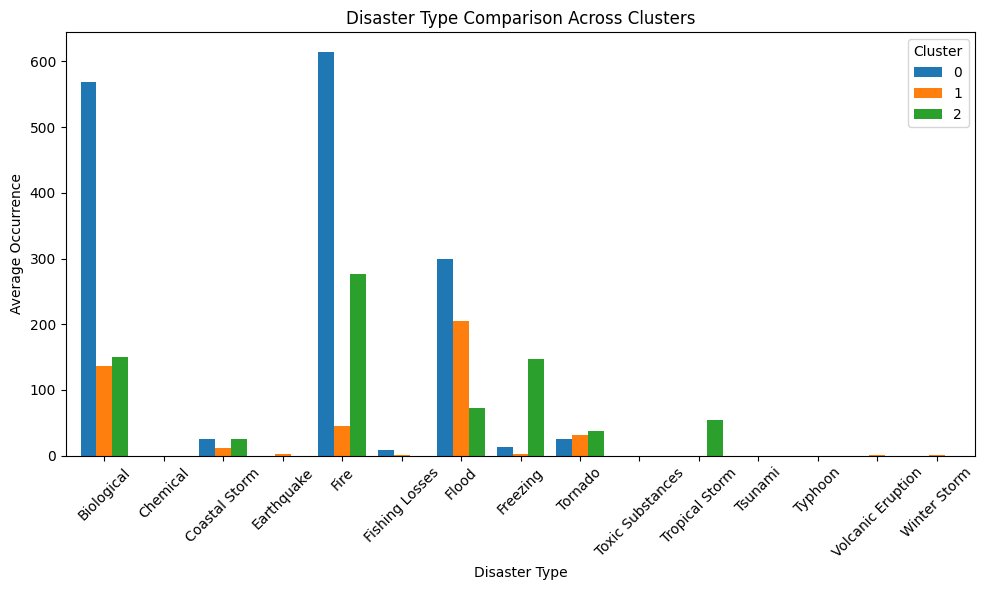

In [14]:

import pandas as pd
import matplotlib.pyplot as plt

# Example data structure
data = {
    "Cluster": [0, 1, 2],
    "Biological": [569, 135.83, 150],
    "Chemical": [0, 0.19, 0],
    "Coastal Storm": [25.5, 11.91, 25],
    "Earthquake": [0, 2.31, 0],
    "Fire": [613.5, 44.744681, 277],
    "Fishing Losses": [8, 0.553191, 0],
    "Flood":[299.5, 205.08506, 73],
    "Freezing":[13.5, 2.702128, 147],
    "Tornado":[25, 31.510638, 38],
    "Toxic Substances":[0, .191489, 0],
    "Tropical Storm":[0, 0, 54],
    "Tsunami": [0, .191489, 0],
    "Typhoon":[0, .042553, 0],
    "Volcanic Eruption":[0, 1.085106, 0],
    "Winter Storm":[0, .914894, 0]

}

df = pd.DataFrame(data).set_index("Cluster")

# Plot
df.T.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title("Disaster Type Comparison Across Clusters")
plt.ylabel("Average Occurrence")
plt.xlabel("Disaster Type")
plt.legend(title="Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Cite: Chat GPT, FEMA Datasets